# Support Vector Machine

```{tip}
It is recommended to use google colaboratory for running the notebook
```

In [ ]:
# Install necessary packages

# Install ray tune and tune sklearn
# ! pip install tune-sklearn ray[tune]

# Install SHAP 
# ! pip install shap

Support vector machines is one of the most prominent methods in the space of supervised learning. Though this algorithm is quite suitable for high dimensional data, it is quite computationally expensive. Also this method does not provide probability estimate. There are different types types of support vector machines for classification based on mathematical formulation - support vector classifier, nu-support vector classifier, and linear support vector classifier. These algorithms constructs hyperplanes which segregates elements in such a manner that the distance between the hyperplane and the closest element of any class is maximum.

In [ ]:
from itertools import compress
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import GenericUnivariateSelect, SelectKBest, mutual_info_classif
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
# Load data into dataframe
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/uci/ospi/datasets/preprocessed_osi.csv')

```{margin}
Make sure to change the path of file depending upon the environment you are working on.
```

## Preprocessing

As usual we will begin our modelling process with the required preprocessing.

In [ ]:
# Separate dependent fron independent variables
y = df['Revenue']
X = df.drop('Revenue', axis=1)

In [ ]:
# Get the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Since SVM doesn't have good performance with huge datasets, it is better to select some handful of features before training the model. To select those feature, SelectKBest API of scikit-learn will be used. To help the API to select features, mutual information will be used. Features with high mutual information score with the target variable will be selected.

In [ ]:
# Feature selection based on mutual information
select_mutual = SelectKBest(mutual_info_classif, k=12)
X_train_mutual = select_mutual.fit_transform(X_train, y_train)
columns = list(compress(X_train.columns, select_mutual.get_support()))
X_train = X_train[columns]
X_test = X_test[columns]
X_train.columns

Index(['Administrative', 'Administrative_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
       'SpecialDay', 'OperatingSystems__3', 'TrafficType__2',
       'VisitorType__Returning_Visitor', 'Month__Nov'],
      dtype='object')

SVM are also not suitable imbalanced classes and hence it is necessary to oversample the minority class before modelling.

In [ ]:
# Oversample the minority class in the target variable
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

Since SVM are computationally expensive, it would be beneficial to scale the values for performace improvement.

In [ ]:
# Scale the data
transformer = MinMaxScaler()
X_train = transformer.fit_transform(X_train)

# Apply same transformation to test set
X_test = transformer.transform(X_test)

## Model training

### SVC with linear kernel

In [ ]:
# Declare the model
estimator = SVC(kernel='linear')

# Declare cross-validation method
cv = StratifiedKFold()

# Declare parameters grid
param_grid = dict(
    C = [0.01, 0.1, 1, 10, 100],

)

In [ ]:
# Import grid search from tune sklearn
from tune_sklearn import TuneGridSearchCV

# Fit the model
linear_svc_clf = TuneGridSearchCV(estimator, param_grid, cv=cv,  n_jobs=-1, verbose=2, use_gpu=True, loggers=["csv"])
linear_svc_clf.fit(X_train, y_train)

In [ ]:
# Print the best estimator
linear_svc_clf.best_estimator_

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Save and load the model if required
# import joblib
# joblib.dump(linear_svc_clf.best_estimator_, '/content/drive/MyDrive/Colab Notebooks/uci/ospi/models/linear_svc.pkl')
# linear_svc_clf = joblib.load('/content/drive/MyDrive/Colab Notebooks/uci/ospi/models/linear_svc.pkl')

In [ ]:
# Use models for prediction
y_pred_linear = linear_svc_clf.predict(X_test)

### SVC with RBF kernel

In [ ]:
# Declare the model
estimator = SVC(kernel='rbf', probability=True)

# Declare cross-validation method
cv = StratifiedKFold()

# Declare parameters grid
param_grid = dict(
    C = [0.01, 0.1, 1, 10, 100],
    gamma = [0.01, 0.1, 1, 10, 100]
)

In [ ]:
# Import grid search from tune sklearn
from tune_sklearn import TuneGridSearchCV

# Fit the model
rbf_svc_clf = TuneGridSearchCV(estimator, param_grid, cv=cv,  n_jobs=-1, verbose=2, use_gpu=True, loggers=["csv"])
rbf_svc_clf.fit(X_train, y_train)

In [ ]:
rbf_svc_clf.best_estimator_

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
# Save and load the model if required
# import joblib
# joblib.dump(rbf_svc_clf.best_estimator_, '/content/drive/MyDrive/Colab Notebooks/uci/ospi/models/rbf_svc.pkl')
# rbf_svc_clf = joblib.load('/content/drive/MyDrive/Colab Notebooks/uci/ospi/models/rbf_svc.pkl')

In [ ]:
# Use models for prediction
y_pred_rbf = rbf_svc_clf.predict(X_test)

## Model Evaluation

In [ ]:
print(classification_report(y_test, y_pred_linear))

              precision    recall  f1-score   support

       False       0.95      0.90      0.93      2594
        True       0.59      0.75      0.66       489

    accuracy                           0.88      3083
   macro avg       0.77      0.83      0.79      3083
weighted avg       0.89      0.88      0.88      3083



In [ ]:
print(classification_report(y_test, y_pred_rbf))

              precision    recall  f1-score   support

       False       0.93      0.93      0.93      2594
        True       0.63      0.60      0.61       489

    accuracy                           0.88      3083
   macro avg       0.78      0.77      0.77      3083
weighted avg       0.88      0.88      0.88      3083



The average F1 score of 0.80 computed with linear kernel is comparable to the F1 scores in the original papers and is better than the one obtained with logistic regression. But on the other hand the F1 score obtained with RBF kernel though worse than the one obtained with logistic regression is not bad either.

## Model Interpretation

It is difficult to interpret support vector machines due to transaformations applied by it to the data with the help of kernels. Linear SVC can be explained more esily that SVC with RBF kernel.

In [ ]:
# Import SHAP
import shap

### Linear SVC interpretation

In [ ]:
# Comput shap values for linear SVC
explainer = shap.Explainer(linear_svc_clf, X_train, feature_names=columns)
shap_values = explainer(X_test)

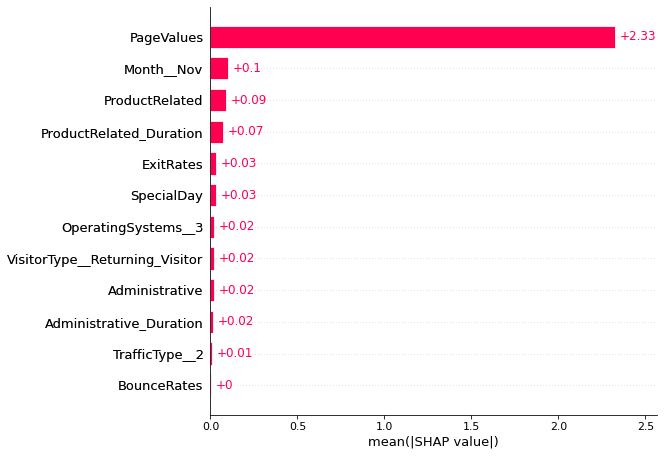

In [ ]:
# Plot shap values with bar chart
shap.plots.bar(shap_values, 12)

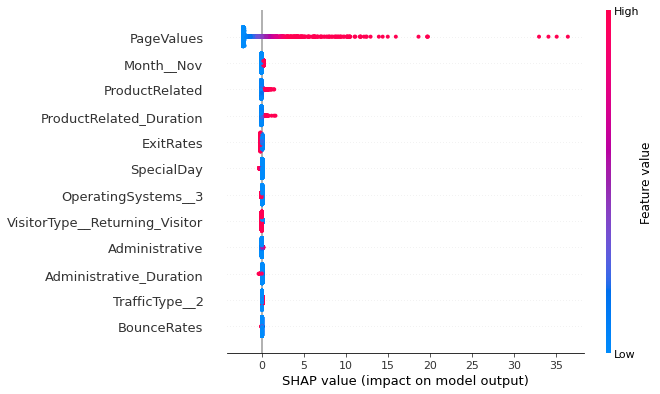

In [ ]:
# Plot beeswarm chart
shap.plots.beeswarm(shap_values, 12)

The information learned by linear SVC algorithm is similar to that of logistic regression. Page value feature has the highest SHAP value i.e. page values affect the highest for converting the visitor. The higher the page value the higher is the chance that the visitor will transact. Higher page values will decrease the chance that a visitor will transact. Also, it can be seen that more the time spent by visitor on product related pages and more the number of product related pages she visits, more the chance of that visitor transacting. 

### SVC with RBF interpretation

In [ ]:
explainer = shap.KernelExplainer(rbf_svc_clf.predict_proba, shap.kmeans(X_train, 100), link="logit")
shap_values = explainer.shap_values(shap.sample(X_test, 5, random_state=1))

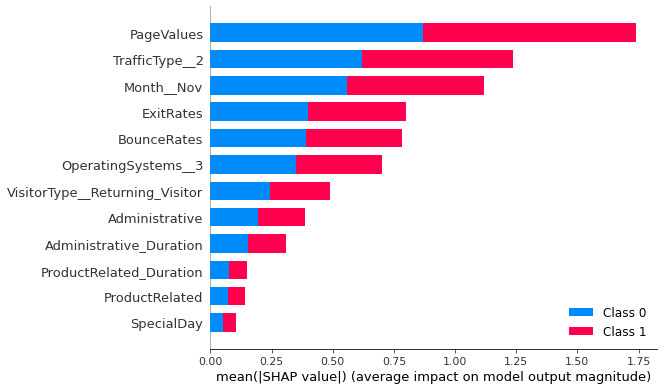

In [ ]:
# Plot summary plot
shap.summary_plot(shap_values, X_test, feature_names=columns, )

SVC with RBF kernel partially agress with the information that SVC with linear kernel has. Page values remains the most important feature. Exit rate also made it to the top 5 features which affects the target. Also, it is surprising to note that the features related to the administrative pages contribute more to the model prediction than the features related to product related pages.

## Learnings

1. Linear SVC could perform better even with 12 features. Further increase in features does not improve the model performance. This also increase the performace of the model.